In [1]:
# First approach to Smart Charging Phase 1 using PuLP.
# Modeled as a PuLP optimisation blending problem
# Started 20 Aug 2020
# Author: Sofia Taylor, Flexible Power Systems

import numpy as np
import pandas as pd
import datetime as dt
from pulp import *
import pickle
import global_variables as gv
import functions as f
import output_functions as of
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import random
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager
import lin_prog_functions as lpf


In [94]:
#grid_file_path = 'Outputs/Logs/grid_variables{}.csv'.format(run)
# journeys_range = pickle.load(open('Outputs/journeys_range','rb'))
# price_data = pickle.load(open('Outputs/price_data','rb'))
empty_profile = pickle.load(open('Outputs/empty_profile','rb'))
charger2 = [11,22]
charger = 20
capacity = 40
ca='opt'
site_capacity = {
    'opt': capacity,  
    'BAU': 10000,
    'BAU2': capacity
}

In [95]:
empty_profile

Electricity_Price  Time_Price       date  \
from                Vehicle_ID                                             
2019-01-31 11:00:00 3                       12.52       0.022 2019-01-31   
                    4                       12.52       0.022 2019-01-31   
                    6                       12.52       0.022 2019-01-31   
                    11                      12.52       0.022 2019-01-31   
                    12                      12.52       0.022 2019-01-31   
...                                           ...         ...        ...   
2019-02-06 10:30:00 3                        9.80       0.309 2019-02-05   
                    4                        9.80       0.309 2019-02-05   
                    6                        9.80       0.309 2019-02-05   
                    11                       9.80       0.309 2019-02-05   
                    12                       9.80       0.309 2019-02-05   

                                Available  Battery_Use  
from                Vehicle_ID                          
2019-01-31 11:00:00 3                   0          0.0  
                    4                   0          0.0  
                    6                   0          0.0  
                    11                  0          0.0  
                    12                  0          0.0  
...                                   ...          ...  
2019-02-06 10:30:00 3                   0          0.0  
                    4                   0          0.0  
                    6                   0          0.0  
                    11                  0          0.0  
                    12                  0          0.0  

[1440 rows x 5 columns]

In [96]:
def linear_optimiser_V4(profile,ca,charger1,charger2,capacity,rel_charge,next_req):#TODO: add mix of chargers here
    """Linear optimisation for a single day charging

    This optimiser uses PuLP to find optimal power outputs over a day.
    Uses 2 different charger powers
    Objective: reduce overall electricity spend
    Constraint 1: get to 100% final SOC before end of time period of next day departures
    Constraint 2: not go below 0% or over 100% battery charge
    Constraint 3: not go over site capacity
    If this is unfeasible, it will atempt to charge as much as possible using
    incomplete_charge.

    Args:
        profile (DataFrame): empty profile of a single day
        ca (str): category to use in optimisation (opt, BAU)
        charger1 (int): slow charger power
        charger2 (int): fast charger power
        capacity (int): max allowed site capacity
        rel_charge (Series): list of intial battery charge state relative to full. 
            Index are Vehicle_ID
        next_req (Series): battery requirements for next day per vehicle

    Returns:
        DataFrame: Outputs for each time period
        LpProblem: variables, objective and constraints
        Series: end of day final SOC for each vehicle
        str: a note on outcomes of the daily optimisation
    """
    profile_av = profile[profile['Available'] == 1]
    price_col = gv.CAT_COLS['PRICE'][ca]
    output_col = gv.CAT_COLS['OUTPUT'][ca]
    vehicles = profile.index.get_level_values(1).unique()
    time_periods = profile_av.index.get_level_values(0).unique()
    # Define output variable
    outputs = LpVariable.dicts(
        "output",
        ((period, vehicle) for period, vehicle in profile_av.index),
        lowBound = 0,
        upBound = charger2 * gv.TIME_FRACT,
        cat = "Continuous"
        )
    ch_assignment = LpVariable.dicts(
        "Charger",
        (vehicle for vehicle in vehicles),
        cat = 'Binary'
    )
    note = ''
    # Create the 'prob' variable to contain the problem data
    prob = LpProblem("Multiple_route_scheduling",LpMinimize)

    # Add costs to objective function
    prob += lpSum(
        [profile_av.loc[(period, vehicle), price_col] * outputs[period, vehicle] 
        for period, vehicle in profile_av.index]
        ), "Total Charging costs"

    # Charge power constraint
    for period, vehicle in profile_av.index:
        prob += outputs[period, vehicle] <= (
            (charger1 + ch_assignment[vehicle] * (charger2-charger1))
            * gv.TIME_FRACT)

    prob += lpSum(
        [ch_assignment[vehicle] for vehicle in vehicles]) == 3

    # Final SOC constraint
    for vehicle in vehicles:
        # Get profile for single vehicle
        vehicle_prof = profile_av.loc[(slice(None),vehicle),'Battery_Use']
        prob += lpSum(
            [outputs[period,vehicle] * gv.CHARGER_EFF for period, vehicle in vehicle_prof.index]
        ) == - (
            profile.loc[(slice(None),vehicle),'Battery_Use'].sum() # Power used that day
            + rel_charge[vehicle] # Initial missing charge
        )

    # Intermediate SOC constraints
    for vehicle in vehicles:
        vehicle_prof = profile_av.loc[(slice(None),vehicle),'Battery_Use']
        for period in vehicle_prof.index.get_level_values(0):
            cumul_use = profile.loc[(slice(period),vehicle),'Battery_Use'].sum()
            cumul_profile = profile_av.loc[(slice(period),vehicle),'Battery_Use']
            prob += lpSum( # Doesn't go over 100% SOC
                [outputs[period, vehicle] * gv.CHARGER_EFF for period, vehicle in cumul_profile.index]
            ) + cumul_use + rel_charge[vehicle]<= 0
            prob += lpSum( # Doesn't go below 0% SOC
                [outputs[period, vehicle] * gv.CHARGER_EFF for period, vehicle in cumul_profile.index]
            ) + cumul_use + rel_charge[vehicle]>= -gv.BATTERY_CAPACITY + charger1 * gv.TIME_FRACT

    # Max capacity constraint
    n = len(time_periods.unique())
    for period in time_periods:
        time_routes = list(profile_av.loc[period].index)
        prob += lpSum(
            [outputs[period, route] for route in time_routes]) <= capacity[ca]* gv.TIME_FRACT

    # Solve and print to the screen
    prob.solve()
    print(ca, "status:", LpStatus[prob.status])
    # If unfeasible, tries to 
    if  prob.status == -1:
        df, note2 = lpf.charge_tonextday(profile,ca,charger1,capacity,rel_charge,next_req)
        note += '\nMain unfeasible'
        note += note2
    else:
        # Get output variables
        charge_output = []
        for period, route in outputs:
            if prob.status == 1:
                x =  outputs[(period, route)].varValue
                y = ch_assignment[route].varValue
            else:
                x = 0
            var_output = {
                'from': period,
                'Vehicle_ID': route,
                output_col: x,
                'Ch':y
            }
            charge_output.append(var_output)

        df = pd.DataFrame.from_records(charge_output).sort_values(['from','Vehicle_ID'])
        df.set_index(['from', 'Vehicle_ID'], inplace=True)
        print('Cost:', value(prob.objective))
    # Generate a final SoC array
    #final_soc = initial_soc
    final_soc = rel_charge + (
        df.groupby('Vehicle_ID').sum()[output_col]*gv.CHARGER_EFF
        + profile.groupby('Vehicle_ID').sum()['Battery_Use'] )
    return df, prob, final_soc, note

In [97]:
## Single Day test
req_energy = empty_profile.groupby(
    ['date','Vehicle_ID']).sum()[['Battery_Use']]*(
        1+gv.MARGIN_SOC)
last_day = req_energy.index[-1][0]+dt.timedelta(days=1)
for v in empty_profile.index.get_level_values('Vehicle_ID').unique():
    req_energy.loc[(last_day,v),'Battery_Use'] = 0
req_energy['Full_Use'] = -gv.BATTERY_CAPACITY
req_energy['Req_Battery'] = req_energy[['Battery_Use','Full_Use']].max(axis=1)
day = gv.DAY
day_profile = f.create_daily_schedule(empty_profile, day)
next_req = req_energy.loc[(day+dt.timedelta(days=1),slice(None)),'Req_Battery'].droplevel(level=0)
initial_rel_charge = pd.Series(
        data = [0,0,0,0,0],
        index = empty_profile.index.get_level_values(1).unique()
    )

output_df, PuLP_prob, fsoc, _ = linear_optimiser_V4(
                    day_profile,
                    ca,
                    charger2[0],charger2[1],
                    site_capacity,
                    initial_rel_charge,
                    next_req
                    )

day_profile_out = day_profile.merge(
                output_df,
                how='left',
                left_index=True,
                right_index=True,
                )
range_profile = day_profile_out.fillna(0)
cols=gv.CAT_COLS
vehicles = output_df.index.get_level_values(1).unique()

range_profile[cols['CHARGE_DEL'][ca]] = (
    range_profile[cols['OUTPUT'][ca]] 
    * gv.CHARGER_EFF)
range_profile[cols['ECOST'][ca]] = (
    range_profile[cols['OUTPUT'][ca]] 
    * range_profile[cols['PRICE']['opt']])
for vehicle in vehicles:
    range_profile.loc[(slice(None),vehicle),cols['SOC'][ca]] = (
        gv.BATTERY_CAPACITY + initial_rel_charge
        + range_profile.loc[(slice(None),vehicle),cols['CHARGE_DEL'][ca]].cumsum() 
        + range_profile.loc[(slice(None),vehicle),'Battery_Use'].cumsum()
        )*100/gv.BATTERY_CAPACITY

opt status: Optimal
Cost: 2689.8421244080005


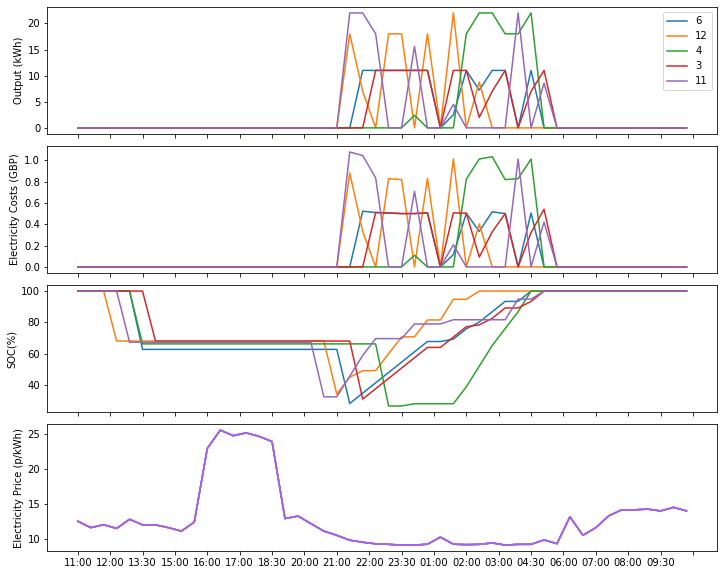

In [98]:
fig, axs = plt.subplots(
    4,
    figsize=(12,10),
    sharex=True, 
    gridspec_kw={'hspace':0.1})

x = range_profile.unstack().index.strftime('%H:%M')
cols = gv.CAT_COLS

axs[0].plot(
    x, 
    range_profile.unstack()[cols['OUTPUT'][ca]]*2)
axs[0].legend(list(vehicles))
axs[0].set_ylabel('Output (kWh)')

axs[1].plot(
    x, 
    range_profile.unstack()[cols['ECOST'][ca]]/100)
axs[1].set_ylabel('Electricity Costs (GBP)')

axs[2].plot(
    x, 
    range_profile.unstack()[cols['SOC'][ca]])
axs[2].set_ylabel('SOC(%)')

axs[3].plot(
    x, 
    range_profile.unstack()[cols['PRICE']['opt']], 
    color=gv.FPS_PURPLE)
axs[3].set_ylabel('Electricity Price (p/kWh)')
for ax in fig.get_axes():
    ax.xaxis.set_major_locator(plt.MaxNLocator(24))
fig.show()

In [99]:
range_profile.sum()

Electricity_Price     3097.000000
Time_Price              10.920000
Available               72.000000
Battery_Use           -260.802633
Output_Opt             289.780704
Ch                      44.000000
ChDelivered_Opt        260.802633
ECost_Opt             2689.842124
SoC_Opt              18778.182827
dtype: float64

Run: 80 / Charger: 22 / Capacity: 30
opt status: Optimal
Cost: 2033.5430175729998
BAU status: Optimal
Cost: 338.61101286460007
BAU2 status: Optimal
Cost: 339.40287949133995
2019-02-27 Status: 3 : 1 1 1
opt status: Infeasible
opt Next required charge status: Optimal
Cost: -26322.139999999996
BAU status: Optimal
Cost: 406.80368715430006
BAU2 status: Infeasible
BAU2 Next required charge status: Optimal
Cost: -28398.857997239174
2019-02-28 Status: -1 : -1 1 -1
opt status: Optimal
Cost: 2138.8807771979996
BAU status: Optimal
Cost: 361.86602823349995
BAU2 status: Optimal
Cost: 370.04716368848
2019-03-01 Status: 3 : 1 1 1
opt status: Optimal
Cost: 0.0
BAU status: Optimal
Cost: 0.0
BAU2 status: Optimal
Cost: 0.0
2019-03-02 Status: 3 : 1 1 1
opt status: Infeasible
opt Next required charge status: Optimal
Cost: -24173.555994627997
BAU status: Infeasible
BAU Next required charge status: Optimal
Cost: -26024.761777489453
BAU2 status: Infeasible
BAU2 Next required charge status: Optimal
Cost: -2602

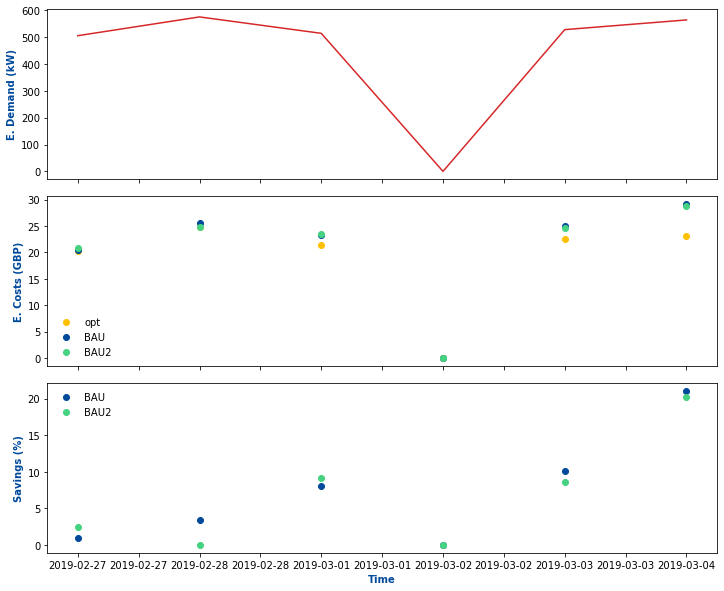

In [17]:
## Range Test

run = 80
notes = 'Introduces empty profile with all dates, fixed charge_tonextday to output as much as possible'

script_strt = time.process_time()
print('Run:',run,'/ Charger:',charger,'/ Capacity:',capacity)
os.makedirs('Outputs/Logs/run{}'.format(run))

profile_out, dates, bad_days, lpprob = lpf.optimise_range2(
    empty_profile, 
    charger, 
    site_capacity)

range_profile, site_profile, days_summary, global_summary = of.summary_outputs(
    profile_out, 
    journeys_range, 
    dates)

os.makedirs('Outputs/Logs/run{}/daily'.format(run))
for date in dates:
    day = dt.datetime.combine(date, dt.datetime.min.time())
    day_profile = of.create_daily_summary(site_profile, day)
    fig_summary = of.summary_plot(day_profile)
    fig_summary.savefig(
        'Outputs/Logs/run{}/daily/fig{}.jpg'.format(run,date))
    plt.close(fig_summary)

with open('Outputs/Logs/run{}/variables{}.csv'.format(run,run),'a') as fi:
    fi.write(notes)
    fi.write('\n' + str(run)+'\n'+str(charger) + '\n' + str(capacity) +'\n')
    fi.write(global_summary.to_string())
    fi.write(bad_days)

range_fig = of.daily_summary_plot(days_summary.fillna(0))
range_fig.savefig(
            'Outputs/Logs/run{}/fig_range{}.svg'.format(run,run),
            bbox_inches = "tight")
range_fig.show()